In [ ]:
!pip install skl2onnx

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from tqdm.notebook import tqdm
from skl2onnx import to_onnx

In [ ]:
# Retreive the data from Donald Bren School of Information and Computer Sciences (ICS)
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip"
!unzip -o "data.zip"

--2022-02-14 17:06:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/00447/data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76601704 (73M) [application/x-httpd-php]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]  73.05M  17.5MB/s    in 4.2s    

2022-02-14 17:06:52 (17.5 MB/s) - ‘data.zip.1’ saved [76601704/76601704]

Archive:  data.zip
  inflating: CE.txt                  
  inflating: CP.txt                  
  inflating: description.txt         
  inflating: EPS1.txt                
  inflating: FS1.txt                 
  inflating: FS2.txt                 
  inflating: profile.txt             
  inflating: PS1.txt                 
  inflating: PS2.txt                 
  inflating: PS3.txt                 
  inflating: PS4.txt                 
  inflating: PS5.txt         

# Prepare the data

Dataset consists of the following features, these are raw and do not have any feature extraction previously applied.


| Sensor | Physical quantity            | Unit  | Sampling rate | 
|--------|------------------------------|-------|---------------| 
| PS1    | Pressure                     | bar   | 100 Hz        | 
| PS2    | Pressure                     | bar   | 100 Hz        | 
| PS3    | Pressure                     | bar   | 100 Hz        | 
| PS4    | Pressure                     | bar   | 100 Hz        | 
| PS5    | Pressure                     | bar   | 100 Hz        | 
| PS6    | Pressure                     | bar   | 100 Hz        | 
| EPS1   | Motor power                  | W     | 100 Hz        | 
| FS1    | Volume flow                  | l/min | 10 Hz         | 
| FS2    | Volume flow                  | l/min | 10 Hz         | 
| TS1    | Temperature                  | C     | 1 Hz          | 
| TS2    | Temperature                  | C     | 1 Hz          | 
| TS3    | Temperature                  | C     | 1 Hz          | 
| TS4    | Temperature                  | C     | 1 Hz          | 
| VS1    | Vibration                    | mm/s  | 1 Hz          | 
| CE     | Cooling efficiency (virtual) | %     | 1 Hz          | 
| CP     | Cooling power (virtual)      | kW    | 1 Hz          | 
| SE     | Efficiency factor            | %     | 1 Hz          | 



In [ ]:
# Import the sensor values as features
sensor_names = ["PS1","PS2","PS3","PS4","PS5","PS6", "EPS1", "FS1", "FS2", "TS1", "TS2", "TS3", "TS4", "VS1", "CE", "CP", "SE"]
feature_list=[]
for i in sensor_names:
    PS=np.genfromtxt(f"{i}.txt")
    feature_list.append(PS)

# Extract the mean value from each of the datapoints
feature_means = {}
for i in range(len(sensor_names)):
  feature_means[sensor_names[i]] = (feature_list[i].mean(axis=1))

In [ ]:
# Convert the feature data to it's final pandas dataframe form
df_features=pd.DataFrame(feature_means)
df_features.shape

(2205, 17)

In [ ]:
# Import the classification target labels
target=np.genfromtxt(r"profile.txt")
df_targets=pd.DataFrame(target,columns=["Cooler_Condition","Valve_Condition","Internal_Pump_Leakage","Hydraulic_Accumulator","Stable_Flag"])
print(df_targets)

      Cooler_Condition  Valve_Condition  ...  Hydraulic_Accumulator  Stable_Flag
0                  3.0            100.0  ...                  130.0          1.0
1                  3.0            100.0  ...                  130.0          1.0
2                  3.0            100.0  ...                  130.0          1.0
3                  3.0            100.0  ...                  130.0          1.0
4                  3.0            100.0  ...                  130.0          1.0
...                ...              ...  ...                    ...          ...
2200             100.0            100.0  ...                   90.0          0.0
2201             100.0            100.0  ...                   90.0          0.0
2202             100.0            100.0  ...                   90.0          0.0
2203             100.0            100.0  ...                   90.0          0.0
2204             100.0            100.0  ...                   90.0          0.0

[2205 rows x 5 columns]


In [ ]:
df_final=pd.concat([df_features,df_targets],axis=1)
df_final.head(10)

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,TS2,TS3,TS4,VS1,CE,CP,SE,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
0,160.673492,109.466914,1.991475,0.0,9.842169,9.728098,2538.929167,6.709815,10.304592,35.621983,40.978767,38.471017,31.745250,0.576950,39.601350,1.862750,59.157183,3.0,100.0,0.0,130.0,1.0
1,160.603320,109.354890,1.976234,0.0,9.635142,9.529488,2531.498900,6.715315,10.403098,36.676967,41.532767,38.978967,34.493867,0.565850,25.786433,1.255550,59.335617,3.0,100.0,0.0,130.0,1.0
2,160.347720,109.158845,1.972224,0.0,9.530548,9.427949,2519.928000,6.718522,10.366250,37.880800,42.442450,39.631950,35.646150,0.576533,22.218233,1.113217,59.543150,3.0,100.0,0.0,130.0,1.0
3,160.188088,109.064807,1.946576,0.0,9.438827,9.337429,2511.541633,6.720565,10.302678,38.879050,43.403983,40.403383,36.579467,0.569267,20.459817,1.062150,59.794900,3.0,100.0,0.0,130.0,1.0
4,160.000472,108.931434,1.922707,0.0,9.358762,9.260636,2503.449500,6.690308,10.237750,39.803917,44.332750,41.310550,37.427900,0.577367,19.787017,1.070467,59.455267,3.0,100.0,0.0,130.0,1.0
5,159.920210,108.887682,1.913285,0.0,9.301160,9.206877,2501.007067,6.699023,10.178720,40.659450,45.170617,42.124117,38.212067,0.572683,19.149683,1.072083,59.563333,3.0,100.0,0.0,130.0,1.0
6,159.672675,108.676466,1.888100,0.0,9.233942,9.143320,2494.416900,6.698573,10.140810,41.463633,45.947233,42.888117,38.932100,0.573033,18.666383,1.081683,59.789900,3.0,100.0,0.0,130.0,1.0
7,159.614452,108.651745,1.874894,0.0,9.194159,9.105058,2489.421533,6.678027,10.095978,42.215267,46.665233,43.519883,39.558967,0.572000,18.178433,1.078700,59.590617,3.0,100.0,0.0,130.0,1.0
8,159.475745,108.529738,1.858120,0.0,9.144616,9.057067,2484.419067,6.671652,10.039710,42.891983,47.339433,44.201250,40.080533,0.567067,18.334867,1.115083,59.608883,3.0,100.0,0.0,130.0,1.0
9,159.437997,108.510885,1.841063,0.0,9.104831,9.019265,2480.434867,6.659990,9.997762,43.532833,47.981417,44.797133,40.612550,0.571683,18.205733,1.129133,59.473733,3.0,100.0,0.0,130.0,1.0


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PS1                    2205 non-null   float64
 1   PS2                    2205 non-null   float64
 2   PS3                    2205 non-null   float64
 3   PS4                    2205 non-null   float64
 4   PS5                    2205 non-null   float64
 5   PS6                    2205 non-null   float64
 6   EPS1                   2205 non-null   float64
 7   FS1                    2205 non-null   float64
 8   FS2                    2205 non-null   float64
 9   TS1                    2205 non-null   float64
 10  TS2                    2205 non-null   float64
 11  TS3                    2205 non-null   float64
 12  TS4                    2205 non-null   float64
 13  VS1                    2205 non-null   float64
 14  CE                     2205 non-null   float64
 15  CP  

In [ ]:
df_final.describe()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,TS2,TS3,TS4,VS1,CE,CP,SE,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,160.485315,109.379906,1.753227,2.600266,9.163320,9.079363,2495.509203,6.198549,9.649453,45.424567,50.365979,47.662121,40.735654,0.613315,31.299077,1.808399,55.287900,41.240816,90.693878,0.669388,107.199546,0.342857
std,4.699425,4.986585,0.251902,4.279355,0.576296,0.549589,73.836682,1.032883,0.449246,7.991933,7.396254,7.451888,8.107878,0.060260,11.575330,0.278263,8.960189,42.383143,10.681802,0.817233,16.435848,0.474772
min,155.391547,104.406307,0.840252,0.000000,8.365801,8.321527,2361.747267,2.018572,8.857513,35.313783,40.859400,38.245733,30.390800,0.524367,17.555983,1.062150,18.276617,3.000000,73.000000,0.000000,90.000000,0.000000
25%,158.100195,106.962382,1.729733,0.000000,8.547239,8.487167,2442.933467,6.391670,9.203397,36.237150,41.864183,39.123183,31.272567,0.555100,20.084650,1.550100,56.270183,3.000000,80.000000,0.000000,90.000000,0.000000
50%,158.960895,107.730169,1.779631,0.000000,9.115781,9.031516,2480.926633,6.576673,9.692270,44.836650,49.780583,47.070250,40.429050,0.610183,27.392533,1.739683,58.758150,20.000000,100.000000,0.000000,100.000000,0.000000
75%,161.000735,109.421612,1.932047,3.503266,9.844351,9.729276,2548.211467,6.657508,10.155008,54.104317,58.584467,55.694433,49.409500,0.649850,46.677383,2.148483,59.656900,100.000000,100.000000,1.000000,130.000000,1.000000
max,180.922708,131.589089,2.023398,10.207068,9.978511,9.856591,2740.641000,6.722707,10.403098,57.899283,61.958467,59.423167,53.060417,0.839067,47.903667,2.840100,60.755300,100.000000,100.000000,2.000000,130.000000,1.000000


In [ ]:
df_final.var()

PS1                        22.084591
PS2                        24.866035
PS3                         0.063454
PS4                        18.312876
PS5                         0.332117
PS6                         0.302048
EPS1                     5451.855603
FS1                         1.066847
FS2                         0.201822
TS1                        63.871000
TS2                        54.704580
TS3                        55.530634
TS4                        65.737688
VS1                         0.003631
CE                        133.988270
CP                          0.077430
SE                         80.284993
Cooler_Condition         1796.330820
Valve_Condition           114.100893
Internal_Pump_Leakage       0.667869
Hydraulic_Accumulator     270.137114
Stable_Flag                 0.225408
dtype: float64

In [ ]:
df_final.corr()

,PS1,PS2,PS3,PS4,PS5,PS6,EPS1,FS1,FS2,TS1,TS2,TS3,TS4,VS1,CE,CP,SE,Cooler_Condition,Valve_Condition,Internal_Pump_Leakage,Hydraulic_Accumulator,Stable_Flag
PS1,1.000000,0.995294,-0.719679,0.043416,-0.125801,-0.124423,0.831429,-0.924036,-0.224179,0.176661,0.148970,0.185098,0.171001,0.442242,-0.044862,-0.065850,-0.943953,-0.002000,-0.152883,0.311859,-0.198940,-0.232049
PS2,0.995294,1.000000,-0.767557,-0.020001,-0.200835,-0.199468,0.787771,-0.946450,-0.295798,0.250480,0.223181,0.258669,0.245184,0.503126,-0.119934,-0.137819,-0.957972,-0.075386,-0.098491,0.309810,-0.180580,-0.206720
PS3,-0.719679,-0.767557,1.000000,0.484111,0.755438,0.754532,-0.268738,0.921187,0.798910,-0.776377,-0.757500,-0.781094,-0.776001,-0.894019,0.697820,0.680701,0.884123,0.662852,0.163278,-0.355070,-0.006242,0.237027
PS4,0.043416,-0.020001,0.484111,1.000000,0.744478,0.744778,0.457372,0.198654,0.688770,-0.706899,-0.709246,-0.704879,-0.718159,-0.661116,0.814459,0.752728,0.125883,0.832446,-0.146385,0.154950,-0.001021,-0.244314
PS5,-0.125801,-0.200835,0.755438,0.744478,1.000000,0.999993,0.418587,0.461261,0.979715,-0.992716,-0.992940,-0.991391,-0.995100,-0.898647,0.973995,0.936972,0.377765,0.949962,0.020317,-0.016579,-0.209262,0.021458
PS6,-0.124423,-0.199468,0.754532,0.744778,0.999993,1.000000,0.419764,0.460014,0.979356,-0.992523,-0.992789,-0.991170,-0.994925,-0.898289,0.974220,0.937112,0.376471,0.950316,0.020284,-0.016262,-0.210282,0.021353
EPS1,0.831429,0.787771,-0.268738,0.457372,0.418587,0.419764,1.000000,-0.608338,0.325387,-0.371933,-0.398269,-0.363958,-0.377500,-0.077260,0.475030,0.433904,-0.677823,0.497514,-0.174618,0.426320,-0.239692,-0.267649
FS1,-0.924036,-0.946450,0.921187,0.198654,0.461261,0.460014,-0.608338,1.000000,0.545412,-0.505347,-0.480062,-0.512708,-0.500738,-0.710475,0.376376,0.382178,0.994564,0.330446,0.190141,-0.421702,0.092695,0.288568
FS2,-0.224179,-0.295798,0.798910,0.688770,0.979715,0.979356,0.325387,0.545412,1.000000,-0.994654,-0.993142,-0.996281,-0.991432,-0.921744,0.919353,0.876955,0.466177,0.881340,0.038651,-0.034926,-0.139471,0.055942
TS1,0.176661,0.250480,-0.776377,-0.706899,-0.992716,-0.992523,-0.371933,-0.505347,-0.994654,1.000000,0.999344,0.999732,0.999242,0.913102,-0.945977,-0.912048,-0.423296,-0.910865,-0.023876,0.019793,0.193597,-0.029021


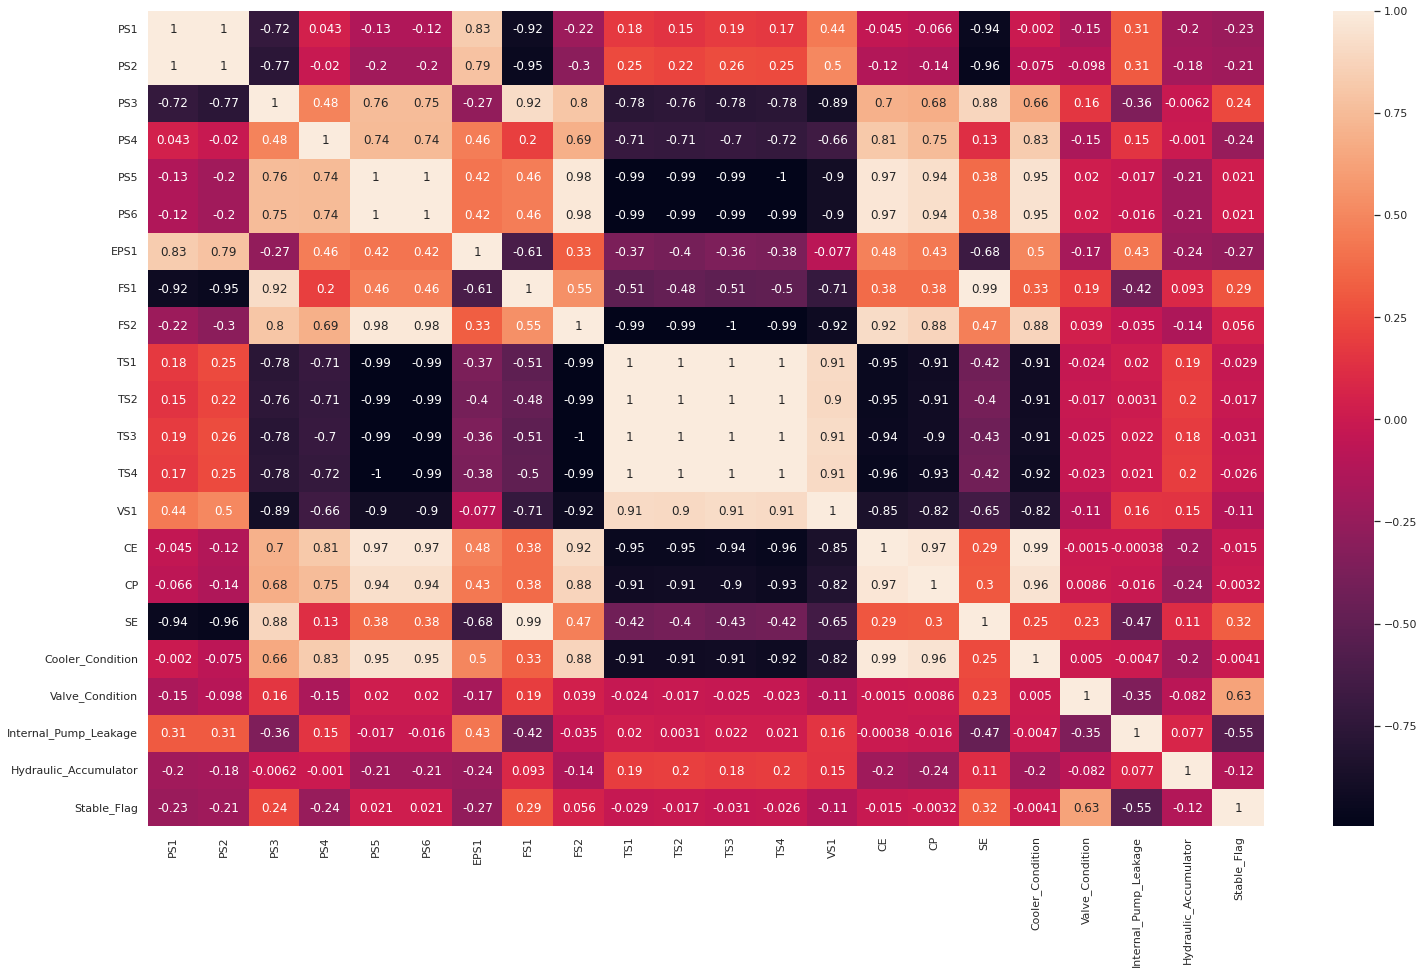

In [ ]:
fig=plt.gcf()
fig.set_size_inches((25,15))
sns.heatmap(df_final.corr(),annot=True)
fig.savefig("corr.png")

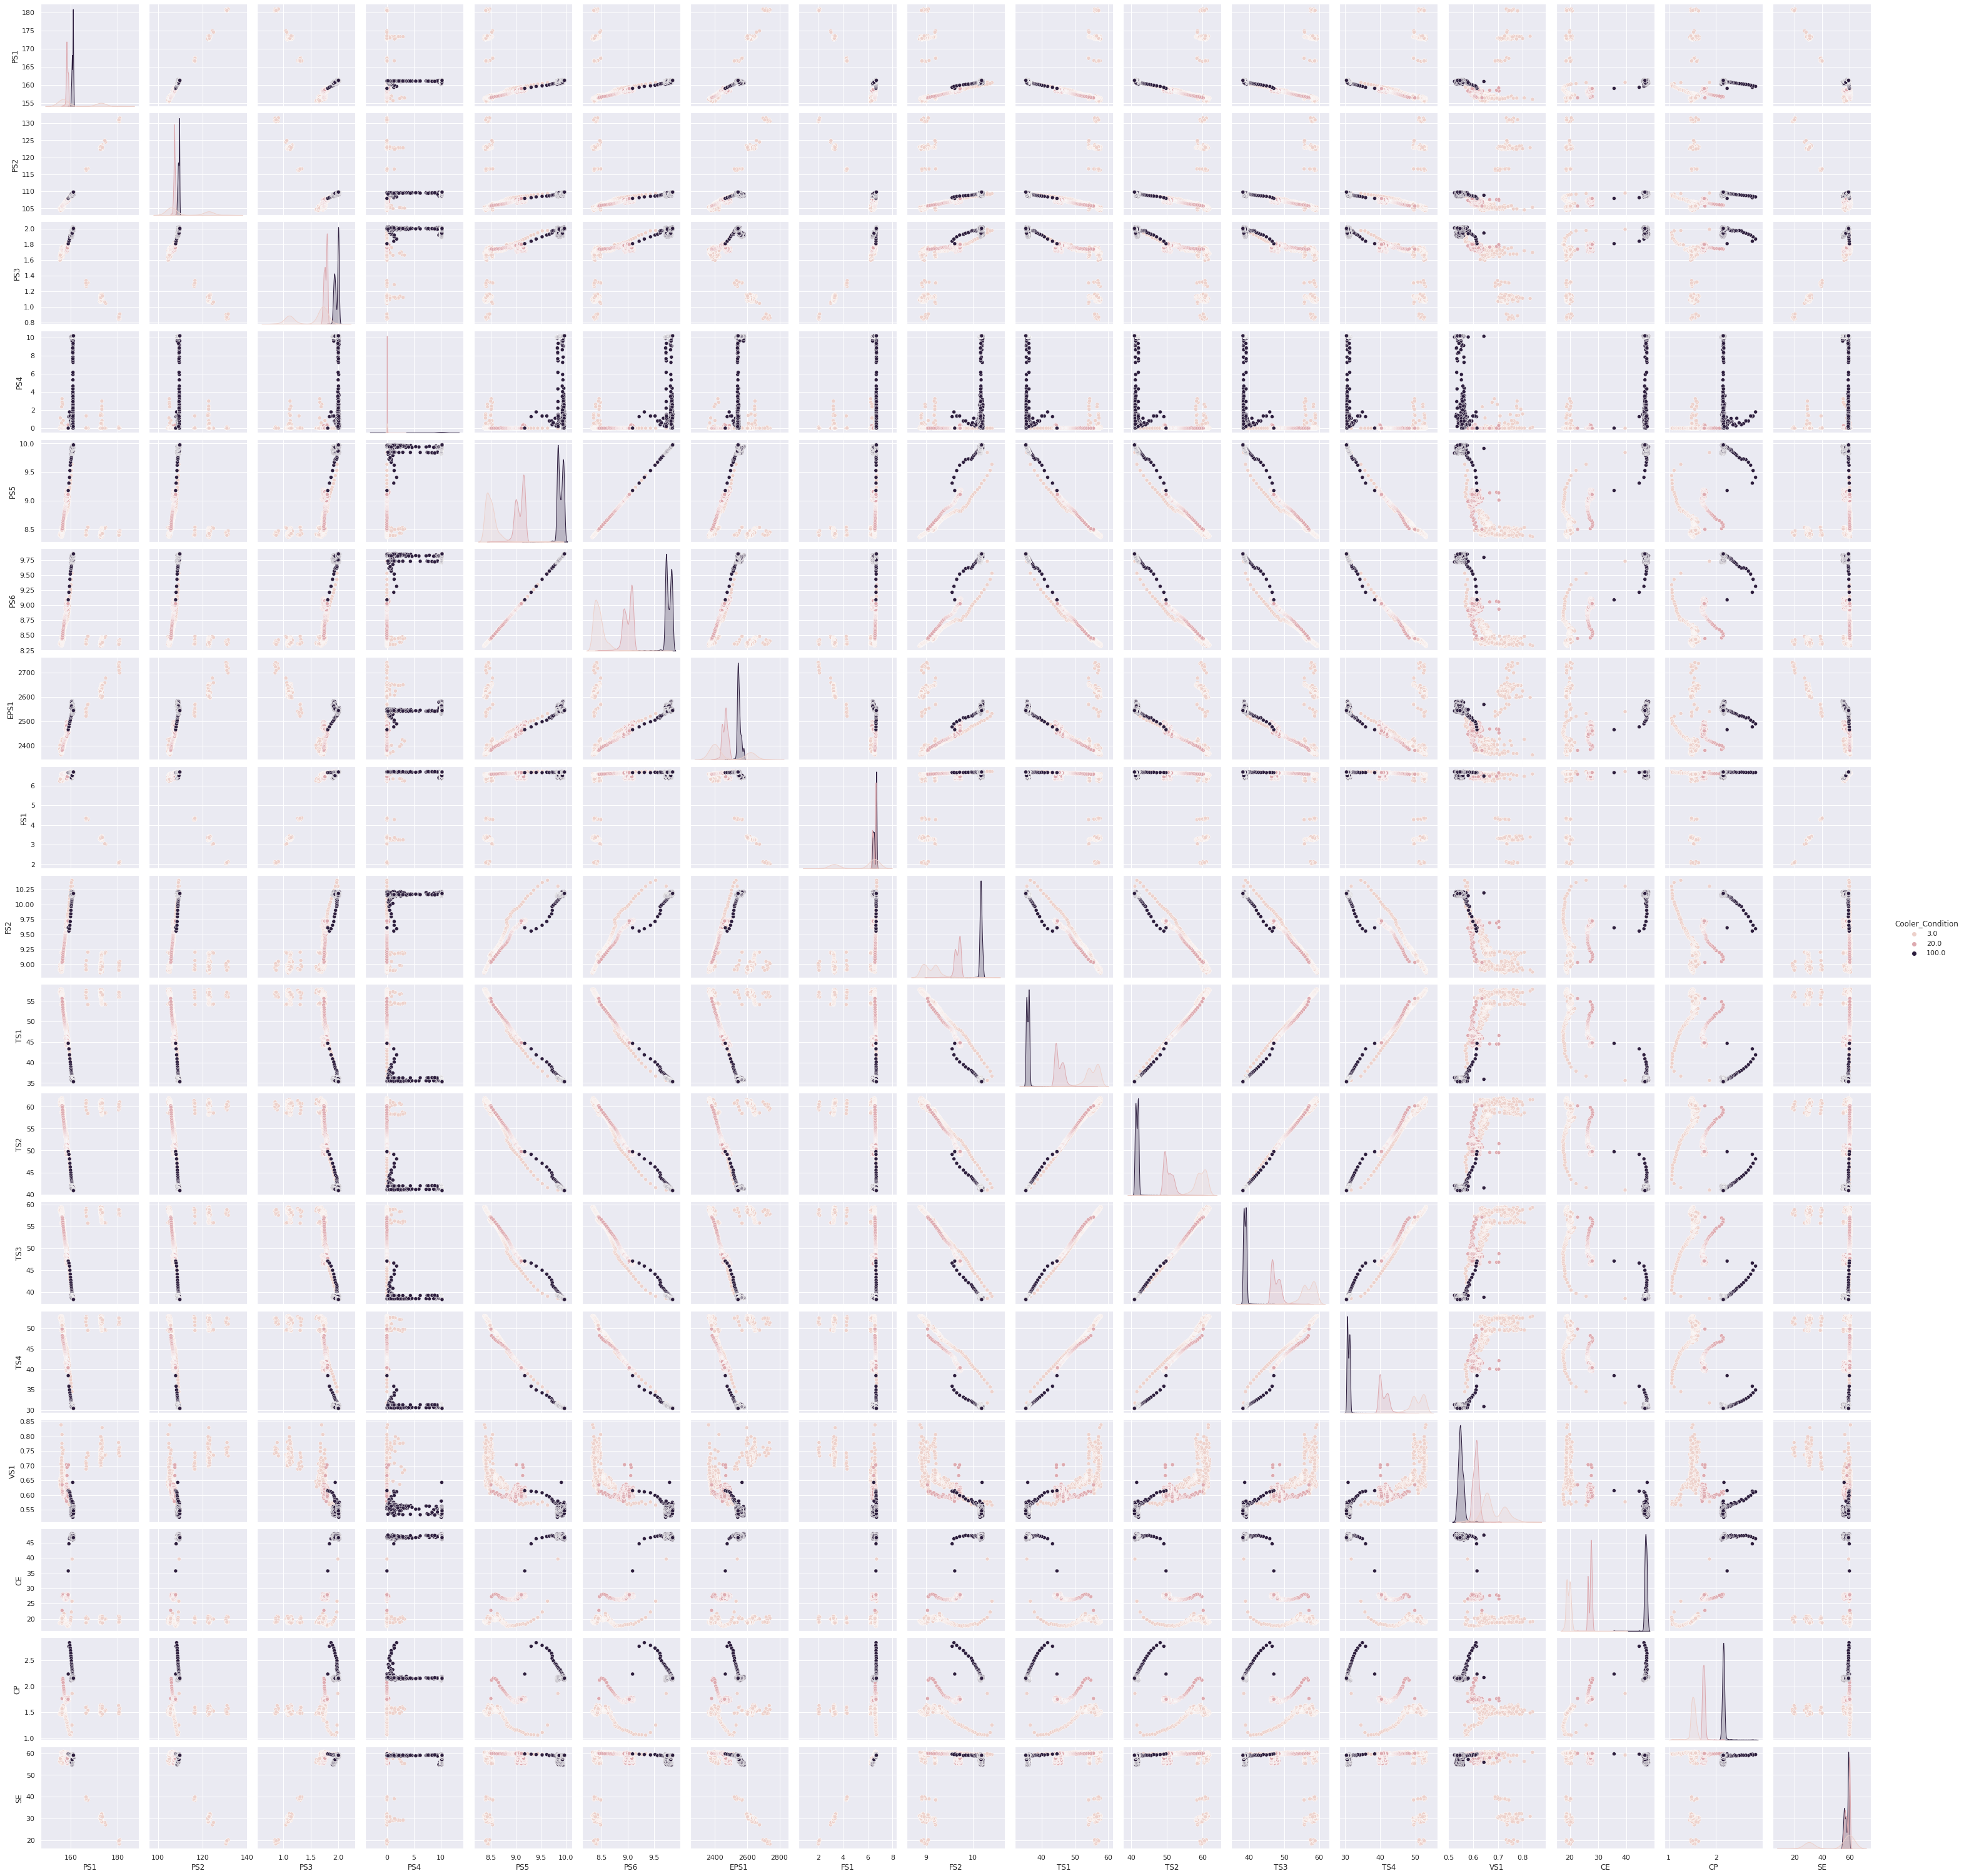

In [ ]:
# Visualize the data via pairplots
sns.pairplot(df_final, hue='Cooler_Condition', vars=['PS1',  'PS2',  'PS3',  'PS4',  'PS5',  'PS6',  'EPS1',  'FS1',  'FS2',  'TS1',  'TS2',  'TS3',  'TS4',  'VS1',  'CE',  'CP',  'SE'])

# Data Preprocessing

In [ ]:
x=df_final.iloc[:,:-5]
y=df_final.iloc[:,-5:]

#Features
print(x.head(2))
#Labels
print(y.head(2))

          PS1         PS2       PS3  ...         CE       CP         SE
0  160.673492  109.466914  1.991475  ...  39.601350  1.86275  59.157183
1  160.603320  109.354890  1.976234  ...  25.786433  1.25555  59.335617

[2 rows x 17 columns]
   Cooler_Condition  Valve_Condition  ...  Hydraulic_Accumulator  Stable_Flag
0               3.0            100.0  ...                  130.0          1.0
1               3.0            100.0  ...                  130.0          1.0

[2 rows x 5 columns]


In [ ]:
# Extract all target columns and convert them to Int
target_1=y.iloc[:,-5]
target_1=(target_1.astype(int))
target_2=y.iloc[:,-4]
target_2=(target_2.astype(int))
target_3=y.iloc[:,-3]
target_3=(target_3.astype(int))
target_4=y.iloc[:,-2]
target_4=(target_4.astype(int))
target_5=y.iloc[:,-1]
target_5=(target_5.astype(int))

# SVM Model - Cooler Condition

In [ ]:
# Using the training data, and the cooler condition data
train_x,test_x,train_y,test_y=train_test_split(x,target_1,test_size=0.2,random_state=1)

# Create a new SVM using the kernel function Radial Basis Function
svc = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel="rbf", decision_function_shape='ovo', gamma='auto'))])
svc.fit(train_x, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(decision_function_shape='ovo', gamma='auto'))])

accuracy_score_svc_train=  0.9982993197278912
accuracy_score_svc_test=  1.0

confusion_matrix:-


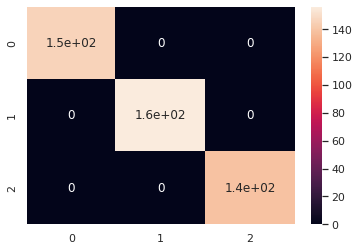

In [ ]:
# Check the accuracy of the model
pred_train_y=svc.predict(train_x)
pred_test_y=svc.predict(test_x)
accuracy_score_svc_train=accuracy_score(train_y,pred_train_y)
accuracy_score_svc_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_svc_train= ",accuracy_score_svc_train)
print("accuracy_score_svc_test= ",accuracy_score_svc_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True)

In [ ]:
precision_score_svc_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_svc_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_svc_train= ",precision_score_svc_train)
print("precision_score_svc_test= ",precision_score_svc_test)

precision_score_svc_train=  0.9982993197278912
precision_score_svc_test=  1.0


In [ ]:
# Convert into ONNX format
onx = to_onnx(svc, train_x[:1].astype(np.float32))

onnx_filename = 'Cooler_Condition.onnx'
with open(onnx_filename,"wb") as f:
    f.write(onx.SerializeToString())

# SVM Model - Pump Condition

In [ ]:
# Using the training data, and the cooler condition data
train_x,test_x,train_y,test_y=train_test_split(x,target_3,test_size=0.2,random_state=1)

# Create a new SVM using the kernel function Radial Basis Function
svc = Pipeline([('scaler', StandardScaler()), ('clf', SVC(kernel="rbf", decision_function_shape='ovo', gamma='auto'))])
svc.fit(train_x, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(decision_function_shape='ovo', gamma='auto'))])

accuracy_score_svc_train=  0.949546485260771
accuracy_score_svc_test=  0.9501133786848073

confusion_matrix:-


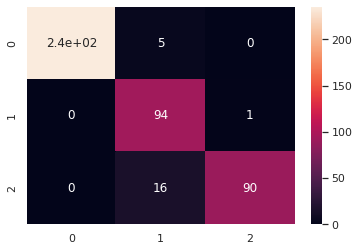

In [ ]:
# Check the accuracy of the model
pred_train_y=svc.predict(train_x)
pred_test_y=svc.predict(test_x)
accuracy_score_svc_train=accuracy_score(train_y,pred_train_y)
accuracy_score_svc_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_svc_train= ",accuracy_score_svc_train)
print("accuracy_score_svc_test= ",accuracy_score_svc_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True)

In [ ]:
precision_score_svc_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_svc_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_svc_train= ",precision_score_svc_train)
print("precision_score_svc_test= ",precision_score_svc_test)

precision_score_svc_train=  0.9529537232067716
precision_score_svc_test=  0.9580211762997921


In [ ]:
# Convert into ONNX format
onx = to_onnx(svc, train_x[:1].astype(np.float32))

onnx_filename = 'Pump_Condition.onnx'
with open(onnx_filename,"wb") as f:
    f.write(onx.SerializeToString())

# SVM Model - Valve Condition

For the valve condition, we have to use PCA and a grid search to find the best values for C and gamma in the SVM.

In [ ]:
# Using the training data, and the cooler condition data
train_x,test_x,train_y,test_y=train_test_split(x,target_2,test_size=0.2,random_state=1)



# Create a new SVM using the kernel function Radial Basis Function, using PCA
svm_pipeline_assembly=[('std_scaler', StandardScaler()),('pca', PCA()),('clf', SVC(kernel="rbf", decision_function_shape='ovo'))]

check_params={
    'pca__n_components' : [17],
    'clf__C' : [0.1,0.5,1,10,30,40,50,75,100,500,1000],
    'clf__gamma' : [0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]}


svm = Pipeline(svm_pipeline_assembly)

#Grid Search to find the best parameters for the SVM
print("Start Fitting Training Data")
for cv in tqdm(range(2,6)):
  svm_grid = GridSearchCV(svm, param_grid=check_params, cv=cv)
  svm_grid.fit(train_x, train_y)
  print("Score for %d fold CV := %3.2f" %(cv, svm_grid.score(train_x, train_y)))
  print("BEST FIT PARAMETERS")
  print(svm_grid.best_params_)

print("Out of search loop")

In [ ]:
# Check the accuracy of the model
pred_train_y=svm_grid.predict(train_x)
pred_test_y=svm_grid.predict(test_x)
accuracy_score_svc_train=accuracy_score(train_y,pred_train_y)
accuracy_score_svc_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_svc_train= ",accuracy_score_svc_train)
print("accuracy_score_svc_test= ",accuracy_score_svc_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True)

In [ ]:
precision_score_svc_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_svc_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_svc_train= ",precision_score_svc_train)
print("precision_score_svc_test= ",precision_score_svc_test)

In [ ]:
# Convert into ONNX format
onx = to_onnx(svm_grid, train_x[:1].astype(np.float32))

onnx_filename = 'Valve_Condition.onnx'
with open(onnx_filename,"wb") as f:
  f.write(onx.SerializeToString())

# SVM Model - Hydraulic accumulator

For the Hydraulic accumulator, we have to use PCA and a grid search to find the best values for C and gamma in the SVM.

In [ ]:
# Using the training data, and the cooler condition data
train_x,test_x,train_y,test_y=train_test_split(x,target_4,test_size=0.2,random_state=1)



# Create a new SVM using the kernel function Radial Basis Function, using PCA
svm_pipeline_assembly=[('std_scaler', StandardScaler()),('pca', PCA()),('clf', SVC(kernel="rbf", decision_function_shape='ovo'))]

check_params={
    'pca__n_components' : [17],
    'clf__C' : [0.1,0.5,1,10,30,40,50,75,100,500,1000],
    'clf__gamma' : [0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]}


svm = Pipeline(svm_pipeline_assembly)

#Grid Search to find the best parameters for the SVM
print("Start Fitting Training Data")
for cv in tqdm(range(2,6)):
  svm_grid = GridSearchCV(svm, param_grid=check_params, cv=cv)
  svm_grid.fit(train_x, train_y)
  print("Score for %d fold CV := %3.2f" %(cv, svm_grid.score(train_x, train_y)))
  print("BEST FIT PARAMETERS")
  print(svm_grid.best_params_)

print("Out of search loop")

In [ ]:
# Check the accuracy of the model
pred_train_y=svm_grid.predict(train_x)
pred_test_y=svm_grid.predict(test_x)
accuracy_score_svc_train=accuracy_score(train_y,pred_train_y)
accuracy_score_svc_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_svc_train= ",accuracy_score_svc_train)
print("accuracy_score_svc_test= ",accuracy_score_svc_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True)

In [ ]:
precision_score_svc_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_svc_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_svc_train= ",precision_score_svc_train)
print("precision_score_svc_test= ",precision_score_svc_test)

In [ ]:
# Convert into ONNX format
onx = to_onnx(svm_grid, train_x[:1].astype(np.float32))

onnx_filename = 'Hydraulic_Accumulator.onnx'
with open(onnx_filename,"wb") as f:
  f.write(onx.SerializeToString())

# SVM Model - Stable Flag

For the Stable Flag, we have to use PCA and a grid search to find the best values for C and gamma in the SVM.

In [ ]:
# Using the training data, and the cooler condition data
train_x,test_x,train_y,test_y=train_test_split(x,target_5,test_size=0.2,random_state=1)



# Create a new SVM using the kernel function Radial Basis Function, using PCA
svm_pipeline_assembly=[('std_scaler', StandardScaler()),('pca', PCA()),('clf', SVC(kernel="rbf", decision_function_shape='ovo'))]

check_params={
    'pca__n_components' : [17],
    'clf__C' : [0.1,0.5,1,10,30,40,50,75,100,500,1000],
    'clf__gamma' : [0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 50]}


svm = Pipeline(svm_pipeline_assembly)

#Grid Search to find the best parameters for the SVM
print("Start Fitting Training Data")
for cv in tqdm(range(2,6)):
  svm_grid = GridSearchCV(svm, param_grid=check_params, cv=cv)
  svm_grid.fit(train_x, train_y)
  print("Score for %d fold CV := %3.2f" %(cv, svm_grid.score(train_x, train_y)))
  print("BEST FIT PARAMETERS")
  print(svm_grid.best_params_)

print("Out of search loop")

In [ ]:
# Check the accuracy of the model
pred_train_y=svm_grid.predict(train_x)
pred_test_y=svm_grid.predict(test_x)
accuracy_score_svc_train=accuracy_score(train_y,pred_train_y)
accuracy_score_svc_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_svc_train= ",accuracy_score_svc_train)
print("accuracy_score_svc_test= ",accuracy_score_svc_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True)

In [ ]:
precision_score_svc_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_svc_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_svc_train= ",precision_score_svc_train)
print("precision_score_svc_test= ",precision_score_svc_test)

In [ ]:
# Convert into ONNX format
onx = to_onnx(svm_grid, train_x[:1].astype(np.float32))

onnx_filename = 'Stable_Flag.onnx'
with open(onnx_filename,"wb") as f:
  f.write(onx.SerializeToString())

# Random Forest Model - Valve condition

In [ ]:
# Using the training data, and the cooler condition data
train_x,test_x,train_y,test_y=train_test_split(x,target_2,test_size=0.2,random_state=1)

rfc=RandomForestClassifier(n_estimators=50,random_state=1)
rfc.fit(train_x,train_y)

In [ ]:
pred_train_y=rfc.predict(train_x)
pred_test_y=rfc.predict(test_x)
accuracy_score_rfc_train=accuracy_score(train_y,pred_train_y)
accuracy_score_rfc_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_rfc_train= ",accuracy_score_rfc_train)
print("accuracy_score_rfc_test= ",accuracy_score_rfc_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True) #overfitting

In [ ]:
precision_score_rfc_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_rfc_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_rfc_train= ",precision_score_rfc_train)
print("precision_score_rfc_test= ",precision_score_rfc_test)   

In [ ]:
scores=cross_validate(rfc,train_x,train_y,scoring=["accuracy","precision_weighted"],cv=10)
scores

In [ ]:
accuracy_score_rfc_cross=scores["test_accuracy"].mean()
print("accuracy_score_rfc_cross= ",accuracy_score_rfc_cross)
precision_score_rfc_cross=scores["test_precision_weighted"].mean()
print("precision_score_rfc_cross= ",precision_score_rfc_cross)

# Random Forest Model - Hydraulic accumulator

In [ ]:
# Using the training data, and the cooler condition data
train_x,test_x,train_y,test_y=train_test_split(x,target_4,test_size=0.2,random_state=1)

rfc=RandomForestClassifier(n_estimators=50,random_state=1)
rfc.fit(train_x,train_y)

In [ ]:
pred_train_y=rfc.predict(train_x)
pred_test_y=rfc.predict(test_x)
accuracy_score_rfc_train=accuracy_score(train_y,pred_train_y)
accuracy_score_rfc_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_rfc_train= ",accuracy_score_rfc_train)
print("accuracy_score_rfc_test= ",accuracy_score_rfc_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True) #overfitting

In [ ]:
precision_score_rfc_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_rfc_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_rfc_train= ",precision_score_rfc_train)
print("precision_score_rfc_test= ",precision_score_rfc_test)   

In [ ]:
scores=cross_validate(rfc,train_x,train_y,scoring=["accuracy","precision_weighted"],cv=10)
scores

In [ ]:
accuracy_score_rfc_cross=scores["test_accuracy"].mean()
print("accuracy_score_rfc_cross= ",accuracy_score_rfc_cross)
precision_score_rfc_cross=scores["test_precision_weighted"].mean()
print("precision_score_rfc_cross= ",precision_score_rfc_cross)

# Random Forest Model - Stable Flag

In [ ]:
# Using the training data, and the cooler condition data
train_x,test_x,train_y,test_y=train_test_split(x,target_5,test_size=0.2,random_state=1)

rfc=RandomForestClassifier(n_estimators=50,random_state=1)
rfc.fit(train_x,train_y)

In [ ]:
pred_train_y=rfc.predict(train_x)
pred_test_y=rfc.predict(test_x)
accuracy_score_rfc_train=accuracy_score(train_y,pred_train_y)
accuracy_score_rfc_test=accuracy_score(test_y,pred_test_y)
print("accuracy_score_rfc_train= ",accuracy_score_rfc_train)
print("accuracy_score_rfc_test= ",accuracy_score_rfc_test)
print("\nconfusion_matrix:-")
sns.heatmap(confusion_matrix(test_y,pred_test_y),annot=True) #overfitting

In [ ]:
precision_score_rfc_train=precision_score(train_y,pred_train_y,average="weighted")
precision_score_rfc_test=precision_score(test_y,pred_test_y,average="weighted")
print("precision_score_rfc_train= ",precision_score_rfc_train)
print("precision_score_rfc_test= ",precision_score_rfc_test)   

In [ ]:
scores=cross_validate(rfc,train_x,train_y,scoring=["accuracy","precision_weighted"],cv=10)
scores

In [ ]:
accuracy_score_rfc_cross=scores["test_accuracy"].mean()
print("accuracy_score_rfc_cross= ",accuracy_score_rfc_cross)
precision_score_rfc_cross=scores["test_precision_weighted"].mean()
print("precision_score_rfc_cross= ",precision_score_rfc_cross)